# CarND-Vehicle-Detection

## Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import os
from fnmatch import fnmatch

## Load traning data 

In [2]:
nv = '.\\data\\non-vehicles\\'
v = '.\\data\\vehicles\\'
pattern = "*.png"
car = []
nocar =[]
file_path = []
lable =[]
for path, subdirs, files in os.walk(nv):
    for name in files:
        if fnmatch(name,pattern):
            nocar.append(os.path.join(path, name))

for path, subdirs, files in os.walk(v):
    for name in files:
        if fnmatch(name,pattern):
            car.append(os.path.join(path, name))

            
            

## Feature extraction functions

Same as the functions provided in udacity exercise with some modifications  

In [3]:
# Convert color spaces  
def convert_color(img, conv='RGB2YUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
# Extract hog features 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Extract spatial features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Extract color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features    
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB2YUV', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = convert_color(image, conv= cspace ) 
        else: 
            feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features


## Visualizing the data

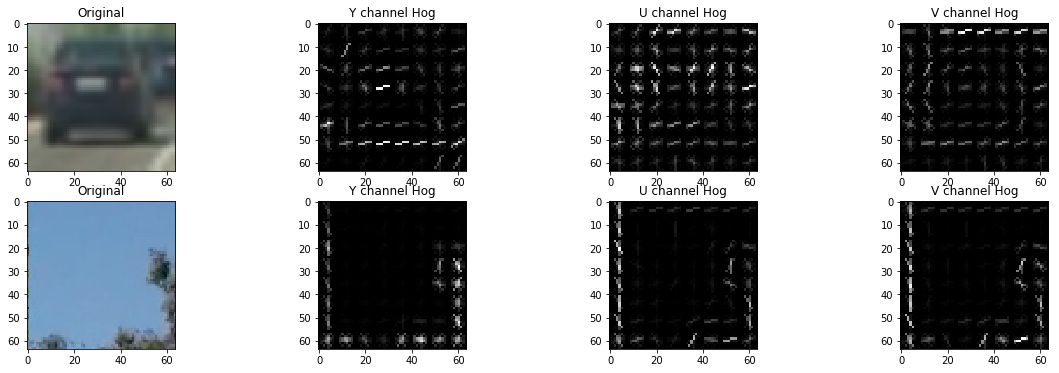

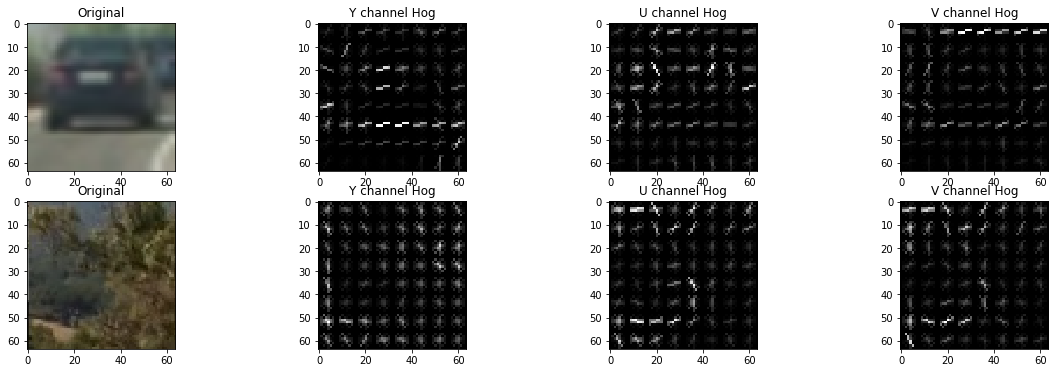

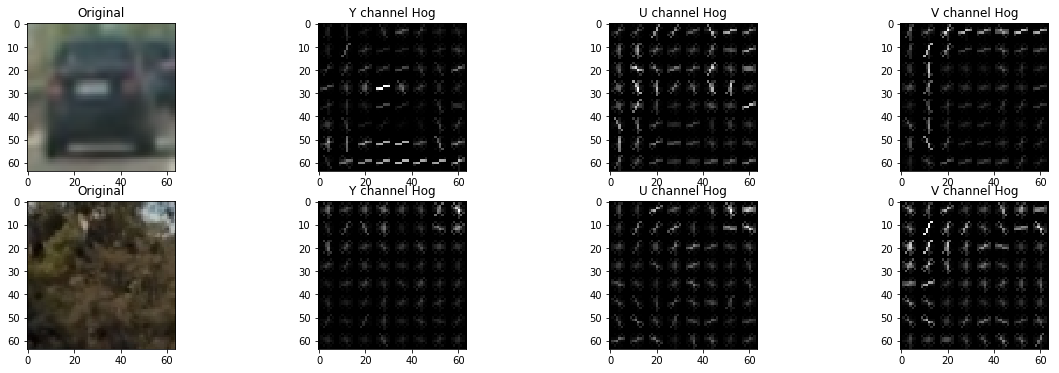

In [4]:
car_images =[]
non_car_images = []
colorspace = 'RGB2YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0

for i in range(3):
    car_images.append(mpimg.imread(car[i]))
    non_car_images.append(mpimg.imread(nocar[i]))
    feature_image_no = convert_color(non_car_images[i], conv= 'RGB2YUV')
    feature_image_car = convert_color(car_images[i], conv= 'RGB2YUV')
    y_ch_car = feature_image_car[:,:,0]
    u_ch_car = feature_image_car[:,:,1]
    v_ch_car = feature_image_car[:,:,2]
    
    y_ch_no = feature_image_no[:,:,0]
    u_ch_no = feature_image_no[:,:,1]
    v_ch_no = feature_image_no[:,:,2]
    
    
    feature_vector,yhog_image_car = hog(y_ch_car, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    feature_vector,uhog_image_car = hog(u_ch_car, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    feature_vector,vhog_image_car = hog(v_ch_car, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
     
    feature_vector,yhog_image_no = hog(y_ch_no, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    feature_vector,uhog_image_no = hog(u_ch_no, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    feature_vector,vhog_image_no = hog(v_ch_no, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    fig = plt.figure(figsize=(20,6))
    ax =fig.add_subplot(2, 4, 1)
    ax.set_title('Original')
    plt.imshow(car_images[i])
    ax =fig.add_subplot(2, 4, 2)
    ax.set_title('Y channel Hog')
    plt.imshow(yhog_image_car, cmap='gray')
    ax =fig.add_subplot(2, 4, 3)
    ax.set_title('U channel Hog')
    plt.imshow(uhog_image_car, cmap='gray')
    ax =fig.add_subplot(2, 4, 4)
    ax.set_title('V channel Hog')
    plt.imshow(vhog_image_car, cmap='gray')
    
    ax =fig.add_subplot(2, 4, 5)
    ax.set_title('Original')
    plt.imshow(non_car_images[i])
    ax =fig.add_subplot(2, 4, 6)
    ax.set_title('Y channel Hog')
    plt.imshow(yhog_image_no, cmap='gray')
    ax =fig.add_subplot(2, 4, 7)
    ax.set_title('U channel Hog')
    plt.imshow(uhog_image_no, cmap='gray')
    ax =fig.add_subplot(2, 4, 8)
    ax.set_title('V channel Hog')
    plt.imshow(vhog_image_no, cmap='gray')
    plt.show()
    
    

## Extract features for traning

In [5]:

colorspace = 'RGB2YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(car, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(nocar, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract all 3 features...')

67.71 Seconds to extract all 3 features...


## Split Traning and Testing Set

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

## Standardize features

Remove the mean (zero) and scale to unit variance

In [7]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

## Train the model 

In [ ]:
from sklearn.svm import SVC
clf = SVC(C=10,verbose=True)
#clf = LinearSVC(C=0.1 verbose=True,max_iter = 1000 )
#clf = CalibratedClassifierCV(svc)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

[LibSVM]

## Check the preciction 

In [ ]:
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

## Function to Perform Hog Sub-sampling Window Search

In [ ]:

    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,allwindow):
    recs =[]
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # Searching only in the right half of the image starting from 720 px
    # Searching only area between ystart and ystop
    # Convert to YUV space
    img_tosearch = img[ystart:ystop,720:,:]
    ctrans_tosearch = convert_color(img_tosearch,conv= 'RGB2YUV')
    # Scale the search area befor extracting hog feature
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Y channel from YUV    
    ch1 = ctrans_tosearch[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_stepx = 2  # Instead of overlap, define how many cells to step
    cells_per_stepy = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_stepx + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_stepy + 1
    
    # Compute individual channel HOG features for the entire search space
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_stepx
            xpos = xb*cells_per_stepy
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1, -1))     
            test_prediction = svc.predict(test_features)
            # If the patch is a car add the rectangel co ordinates to list
            if test_prediction == 1 or allwindow  :
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                recs.append([(xbox_left+720, ytop_draw+ystart),(xbox_left+win_draw+720,ytop_draw+win_draw+ystart)]) 
                
    return recs

## Visualize All windows Windows 

In [ ]:
draw_img = mpimg.imread('./test_images/test1.jpg')
# Search areas for various size
y_limits =[350,520,370,600,400,700]
# Scaling factor
scales = [1,2,3]
spatial_size = (32, 32)
hist_bins = 32
all_wind=[]

for i in range(len(scales)):
    all_wind+=(find_cars(draw_img , y_limits[i*2], y_limits[i*2+1], scales[i], clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,True))    
# list out all the rectangles
for points in all_wind:
    cv2.rectangle(draw_img, points[0], points[1], (0,0,255), 4)
fig = plt.figure(figsize=(20,10))    
plt.imshow(draw_img)
print('Total no of windows considerd :',len(all_wind))

## Functions for removing False Positives

Heatmap and a Threshold are used to remove false positives

In [ ]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if abs( bbox[1][0]- bbox[0][0]) > 30:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def heat_map(img,recmard):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    heat = add_heat(heat,recmard)
    
    # Apply threshold to help remove false positives
    heat_thresh = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresh, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img,heat,heat_thresh,heatmap 

## Pipeline 

In [ ]:
rectang1 = []
j=0

# Processing Pipeline
def pipv1(image):
    draw_img = np.copy(image)
    global rectang1,j
    # Search areas for various size
    y_limits =[350,520,370,600,400,700]
    # Scaling factor
    scales = [1,2,3]
    spatial_size = (32, 32)
    hist_bins = 32
    # Procrsss every 8th frame in the window i.e out of 24 frames 3 will be processed.
    if j % 8 == 0:
        rectang1 =[]
        for i in range(len(scales)):
            rectang1+=(find_cars(image, y_limits[i*2], y_limits[i*2+1], scales[i], clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))    
    # use heat map to filter out false positives
    draw_img,heat,heat_thresh,heatmap  = heat_map(image,rectang1)
    
    j+=1
    
    return draw_img

# pipeline for diagnostics
def pip_diagnostics(image):
    draw_img = np.copy(image)
    # Search areas for various size
    y_limits =[350,520,370,600,400,700]
    # Scaling factor
    scales = [1,2,3]
    spatial_size = (32, 32)
    hist_bins = 32
    # Procrsss every 8th frame in the window i.e out of 24 frames 3 will be processed.
    rectang1 =[]
    for i in range(len(scales)):
        rectang1+=(find_cars(image, y_limits[i*2], y_limits[i*2+1], scales[i], clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))    
    # use heat map to filter out false positives
    draw_img,heat,heat_thresh,heatmap = heat_map(image,rectang1)
    
    return draw_img,heat,heat_thresh,heatmap,rectang1 
    

## Run the diagnostics pipeline on Test images 

In [ ]:
%matplotlib inline

for k in range(1,7):
    j=0
    img = mpimg.imread('./test_images/test'+str(k)+'.jpg')
    raw = np.copy(img)
    draw_img,heat,heat_thresh,heatmap,rec  = pip_diagnostics(img)
    mpimg.imsave('./output_images/v'+str(k)+'.jpg',draw_img)
    for points in rec:
        cv2.rectangle(raw, points[0], points[1], (0,0,255), 4)
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title('Original')
    plt.imshow(img)
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title('All Dectected Windows')
    plt.imshow(raw)
    ax = fig.add_subplot(1, 4, 3)
    ax.set_title('Heatmap with Threshold')
    plt.imshow(heat , cmap='hot')
    ax = fig.add_subplot(1, 4, 4)
    ax.set_title('Final Dectection')
    plt.imshow(draw_img)
    plt.show()
    

## Run the Pipeline for the video

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
rectang1 = []
all_rec =[]
j=0
video_output = 'project_video_processed.mp4'
clip = VideoFileClip("project_video.mp4")
#clip = clip.subclip(33,43)
video_clip = clip.fl_image(pipv1)
%time video_clip.write_videofile(video_output, audio=False)
video_clip.reader.close()
video_clip.audio.reader.close_proc()